### **SIR Model Parameters Estimation**

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
np.random.seed(1)
# from tqdm import tqdm

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.optimize as optimize

In [16]:
# est_R_0 = np.array([0.9] * 26)
# est_R_0 = np.random.normal(2, 0.5, size=(26,))
# est_R_0 = np.concatenate((np.random.normal(1, 0.5, size=(13,)), np.random.normal(2, 0.5, size=(13,))), axis=0)
# t_set = np.linspace(0, 765, 766)

def loss_func(est_R_0, I_true, t_length, type_loss_func, state, plot=False):
    t_set = np.linspace(0, t_length - 1, t_length)

    gamma = 1./14

    N_dict = {
        "NJ": 9288994,
        "NY": 20201249,
        "CA": 39538223,
        "IL": 12812508,
        "PA": 13002700
    }

    N = N_dict[state]
    I0, R0 = 20, 0
    S0 = N - I0 - R0
    y0 = S0, I0, R0
    est_R_0 = np.abs(est_R_0)
    
    def random_beta(t):
        idx = int(t//30)
        idx = t_length//30 - 1 if idx >= t_length//30 else idx
        idx = 0 if idx < 0  else idx
        return est_R_0[idx] * gamma
    
    def deriv_dynamic(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = - beta(t) * S * I / N
        dIdt = beta(t) * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt
    
    ret = odeint(deriv_dynamic, y0, t_set, args=(N, random_beta, gamma))
    _, I, _ = ret.T
    
    loss = type_loss_func(I_true, I/N)
    
    if plot:
        fig, ax = plt.subplots()
        ax.plot(range(len(I_true)), I_true, label='True')
        ax.plot(range(len(I_true)), I / N, label='Pred')
        plt.legend()
        plt.show()
            
    return loss


In [4]:
# Import data 
N_NJ = 9288994
N_NY = 20201249
N_CA = 39538223
N_IL = 12812508
N_PA = 13002700

with open("NJ.txt") as f:
    string_NJ = f.readline()
NJ_data = np.array(string_NJ.split(",")).astype("float")/N_NJ

with open("NY.txt") as f:
    string_NY = f.readline()
NY_data = np.array(string_NJ.split(",")).astype("float")/N_NY

with open("CA.txt") as f:
    string_CA = f.readline()
CA_data = np.array(string_CA.split(",")).astype("float")/N_CA

with open("IL.txt") as f:
    string_IL = f.readline()
IL_data = np.array(string_IL.split(",")).astype("float")/N_IL

with open("PA.txt") as f:
    string_PA = f.readline()
PA_data = np.array(string_PA.split(",")).astype("float")/N_PA

In [5]:
time_period = [180, 320, 265]

In [6]:
# NJ Period 0
# t_set = np.linspace(0, 765, 766)
optimzer_mae_nj0 = optimize.minimize(loss_func, 
                                     np.random.normal(1, 1, size=(time_period[0]//30,)), 
                                     args=(NJ_data[:time_period[0]], time_period[0], mean_absolute_error, "NJ"), 
                                     method='Nelder-Mead', options={'maxiter':2000, 'disp':True})
optimzer_mse_nj0 = optimize.minimize(loss_func, 
                                     np.random.normal(1, 1, size=(time_period[0]//30,)), 
                                     args=(NJ_data[:time_period[0]], time_period[0], mean_squared_error, "NJ"), 
                                     method='Nelder-Mead', options={'maxiter':2000, 'disp':True})

Optimization terminated successfully.
         Current function value: 0.000818
         Iterations: 505
         Function evaluations: 793
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 491
         Function evaluations: 797


In [39]:
# NJ Period 1
optimzer_mae_nj1 = optimize.minimize(loss_func, 
                                     np.random.normal(1, 1, size=(time_period[1]//30,)), 
                                     args=(NJ_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], mean_absolute_error, "NJ"), 
                                     method='Nelder-Mead',
                                     tol=1e-2,
                                     options={'maxiter':5000, 'disp':True})

optimzer_mse_nj1 = optimize.minimize(loss_func, 
                                     np.random.normal(1, 1, size=(time_period[1]//30,)), 
                                     args=(NJ_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], mean_squared_error, "NJ"), 
                                     method='Nelder-Mead',
                                     tol=1e-2,
                                     options={'maxiter':5000, 'disp':True})

Optimization terminated successfully.
         Current function value: 0.004024
         Iterations: 1041
         Function evaluations: 1463
Optimization terminated successfully.
         Current function value: 0.000040
         Iterations: 800
         Function evaluations: 1126


In [40]:
est_r0_period_1 = np.abs(optimzer_mse_nj1.x)
est_r0_period_1

array([4.69863754, 0.22998543, 2.70959673, 0.26466126, 1.98653803,
       0.76033256, 1.28637131, 1.39848398, 0.56869946, 1.16776305])

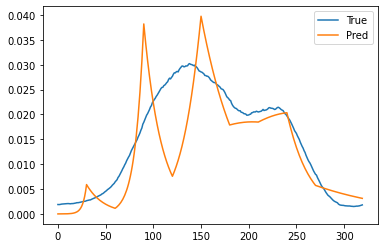

4.000389387768635e-05

In [41]:
loss_func(est_r0_period_1, NJ_data[time_period[0]:time_period[0] + time_period[1]], time_period[1], mean_squared_error, 'NJ', True)

In [22]:
# NJ Period 2
optimzer_mae_nj2 = optimize.minimize(loss_func, 
                                     np.random.normal(2, 1, size=(time_period[2]//30,)), 
                                     args=(NJ_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], mean_absolute_error, "NJ"), 
                                     method='Nelder-Mead', 
                                     options={'maxiter':2000, 'disp':True})

optimzer_mse_nj2 = optimize.minimize(loss_func, 
                                     np.random.normal(2, 1, size=(time_period[2]//30,)), 
                                     args=(NJ_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], mean_squared_error, "NJ"), 
                                     method='Nelder-Mead', 
                                     options={'maxiter':2000, 'disp':True})

Optimization terminated successfully.
         Current function value: 0.003840
         Iterations: 953
         Function evaluations: 1434
Optimization terminated successfully.
         Current function value: 0.000047
         Iterations: 1498
         Function evaluations: 2222


In [23]:
est_r0_period_2 = np.abs(optimzer_mae_nj2.x)
est_r0_period_2

array([1.22598989, 2.51097524, 3.26687429, 0.85217596, 1.54765093,
       1.94743247, 1.44101522, 0.24334169])

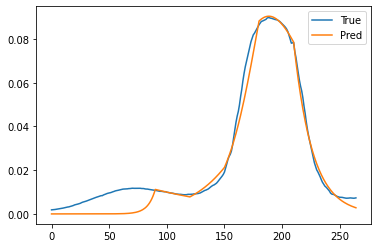

2.8756685126154554e-05

In [25]:
loss_func(est_r0_period_2, NJ_data[time_period[0] + time_period[1]:time_period[0] + time_period[1] + time_period[2]], time_period[2], mean_squared_error, 'NJ', True)

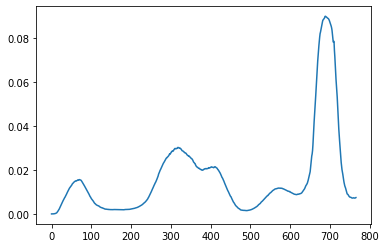

In [21]:
plt.plot(range(len(NJ_data)), NJ_data)

In [22]:
# NJ
r0_pred = np.concatenate((np.abs(optimzer_mse_nj0.x), np.abs(optimzer_mse_nj1.x), np.abs(optimzer_mse_nj2.x)))

In [35]:
r0_pred


array([4.8507628 , 1.34503835, 0.89640546, 0.44503617, 0.02432075,
       2.30596986, 0.09843952, 6.20500975, 0.56650836, 1.78614248,
       1.03037392, 1.21595422, 1.05691613, 1.6       , 0.57499414,
       1.1394036 , 5.45520449, 0.83844018, 1.21848025, 0.81636549,
       0.59148035, 0.3553112 , 2.3       , 1.4097475 ])

In [34]:
r0_pred[13] = 1.6
r0_pred[22] = 2.3

C:\Users\Claire\anaconda3\envs\decision-analytics\lib\site-packages\ipykernel_launcher.py:62: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


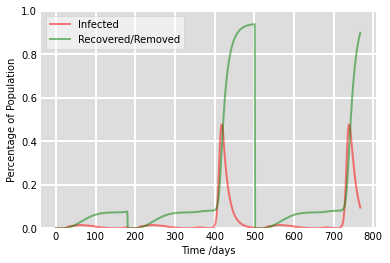

In [42]:
gamma = 1./14
state = "NJ"

N_dict = {
    "NJ": 9288994,
    "NY": 20201249,
    "CA": 39538223,
    "IL": 12812508,
    "PA": 13002700
}

N = N_dict[state]
time_period = [180, 320, 265]

I0, R0 = 20, 0
S, I, R = np.array([]), np.array([]), np.array([])
for i in range(3):
    
    S0 = N - I0 - R0
    y0 = S0, I0, R0

    def random_beta(t):
        idx = int(t // 30)
        idx = time_period[i] // 30 - 1 if idx >= time_period[i] // 30 else idx
        idx = 0 if idx < 0  else idx
        # return r0_pred[idx] * gamma
        return r0_pred[idx] * gamma
        # max_idx = len(r0_preds[i]) - 1
        # if idx > max_idx:
        #     return r0_preds[i][max_idx]
        # elif idx < 0:
        #     return r0_preds[i][0]
        # else:
        #     return r0_preds[i][idx]


    def deriv_dynamic(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = - beta(t) * S * I / N
        dIdt = beta(t) * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    ret = odeint(deriv_dynamic, y0, np.linspace(0, time_period[i], time_period[i] + 1), args=(N, random_beta, gamma))
    S_period, I_period, R_period = ret.T
    S = np.concatenate((S, S_period))
    I = np.concatenate((I, I_period))
    R = np.concatenate((R, R_period))
    # I0, R0 = I[-1], R[-1]


fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
# ax.plot(t_set, S/N_NJ, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(range(len(I)), I/N_NJ, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(range(len(I)), R/N_NJ, 'g', alpha=0.5, lw=2, label='Recovered/Removed')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.set_ylim(0,1)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

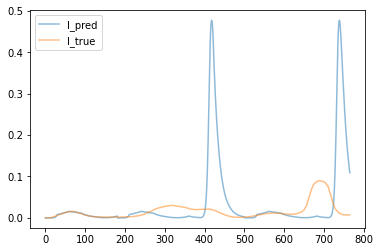

In [43]:
fig, ax = plt.subplots()

ax.plot(list(range(766)), I[:766]/N_NJ, label="I_pred", alpha=0.5)
ax.plot(list(range(766)), NJ_data, label="I_true", alpha=0.5)
plt.legend()
plt.show()

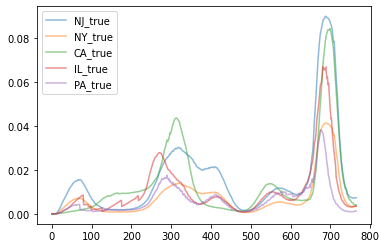

In [10]:
fig, ax = plt.subplots()
ax.plot(list(range(766)), NJ_data, label="NJ_true", alpha=0.5)
ax.plot(list(range(766)), NY_data, label="NY_true", alpha=0.5)
ax.plot(list(range(766)), CA_data, label="CA_true", alpha=0.5)
ax.plot(list(range(766)), IL_data, label="IL_true", alpha=0.5)
ax.plot(list(range(766)), PA_data, label="PA_true", alpha=0.5)
plt.legend()
plt.show()

In [106]:
# ### ------------------- Parameters to Vary ------------------- ###

# # lambda: number of people that a susceptible person interacts with per time step
# # p: probability of getting infected if a susceptible person interacts with an infectious person
# # gamma: recovery rate (recovery probability within one time step)
# gamma = 1./14 # set lam = 2 vs 20, p = 0.3, gamma = 1/14

# ### ------------------- Fixed Parameters ------------------- ###

# # Total population.
# N_NJ = 9288994
# N_NY = 20201249
# N_CA = 39538223
# N_IL = 12812508
# N_PA = 13002700

# # A grid of time points (in days) for the detecting period
# t_set = np.linspace(0, 765, 766)

# # Initial number of infected and immune individuals, I0 and R0.
# I0, R0 = 10, 0

# # Everyone else, S0, is susceptible to infection initially.
# S0 = N - I0 - R0

# # The SIR model differential equations.
# def deriv_dynamic(y, t, N, beta, gamma):
#     S, I, R = y
#     dSdt = -beta(t) * S * I / N
#     dIdt = beta(t) * S * I / N - gamma * I
#     dRdt = gamma * I
#     return dSdt, dIdt, dRdt

# x = np.linspace(0, 367, 368)

# def random_beta(t):
        
#     if t < 36:
#         return r0_pred[0]
#     if 36 <= t < 72:
#         return r0_pred[1]
#     if 72 <= t < 108:
#         return r0_pred[2]
#     if 108 <= t < 144:
#         return r0_pred[3]
#     if 144 <= t < 180:
#         return r0_pred[4]
#     if 180 <= t < 216:
#         return r0_pred[5]
#     if 216 <= t < 248:
#         return r0_pred[6]
#     if 248 <= t < 284:
#         return r0_pred[7]
#     if 284 <= t < 320:
#         return r0_pred[8]
#     if t > 320:
#         return r0_pred[9]

# ### ----------------- Dynamic Parameters ----------------- ###

# # Initial conditions vector
# y0 = S0, I0, R0
# # Integrate the SIR equations over the time grid, t.
# ret = odeint(deriv_dynamic, y0, t_set, args=(N, random_beta, gamma))
# S_pred, I_pred, R_pred = ret.T

# # Plot the data on three separate curves for S(t), I(t) and R(t)
# fig = plt.figure(facecolor='w')
# ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
# ax.plot(t_set, S_pred/N, 'b', alpha=0.5, lw=2, label='Susceptible')
# ax.plot(t_set, I_pred/N, 'r', alpha=0.5, lw=2, label='Infected')
# ax.plot(t_set, R_pred/N, 'g', alpha=0.5, lw=2, label='Recovered/Removed')
# ax.set_xlabel('Time /days')
# ax.set_ylabel('Percentage of Population')
# ax.set_ylim(0,1.2)
# ax.yaxis.set_tick_params(length=0)
# ax.xaxis.set_tick_params(length=0)
# ax.grid(b=True, which='major', c='w', lw=2, ls='-')
# legend = ax.legend()
# legend.get_frame().set_alpha(0.5)
# for spine in ('top', 'right', 'bottom', 'left'):
#     ax.spines[spine].set_visible(False)
# plt.show()

In [107]:
# fig, ax = plt.subplots()

# ax.plot(list(range(366)), I_pred, label="I_pred", alpha=0.5)
# ax.plot(list(range(366)), I_syn, label="I_true", alpha=0.5)
# plt.legend()
# plt.show()